In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.patches import Patch
import itertools
from collections import deque
import seaborn as sns
df = pd.read_excel("BS_EN_Dataset.xlsx")

#Print the list of steel classifications
df.Classification.unique()

array(['Non-alloy steels',
       'Structural, pressure vessel and engineering steels',
       'Non-alloy special steels', 'Alloy Steels',
       'Non-alloy Quality steels'], dtype=object)

In [36]:
##Functions to expand rows
#yield or tensile is a range
def expand_row(row, feature, k): #row = df.iloc[[i]], i = 0:139
    feat_range = row.reset_index()[feature][0].split("-")
    feat_range = list(np.linspace(int(feat_range[0]), int(feat_range[1]), k))
    feat_range = [int(i) for i in feat_range]
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    row[feature] = feat_range
    return row

#yield and tensile are ranges
def expand_row_2(row, k):
    yield_range = row.reset_index()["Yield Strength"][0].split("-")
    mean_yield = int((int(yield_range[0]) + int(yield_range[1])) / 2)
    row = row.reset_index()
    row.at[0, "Yield Strength"] = mean_yield
    return expand_row(row, "Tensile Strength", k)

#yield and tensile are not ranges
def expand_row_3(row, k):
    feat_range = list(np.linspace(row["Tensile Strength"] - 7, row["Tensile Strength"] + 7, k))
    feat_range = [int(i) for i in feat_range]
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    row["Tensile Strength"] = feat_range
    return row

#Create expanded dataset
def expand_df(df, k):
    df2 = pd.DataFrame(columns=list(df.columns))
    for i in range(len(df)):
        row = df.iloc[[i]]
        if type(row.reset_index()["Tensile Strength"][0]) == str and type(row.reset_index()["Yield Strength"][0]) != str:
            expanded_row = expand_row(row, "Tensile Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row(row, "Yield Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) == str:
            expanded_row = expand_row_2(row, k)
        elif type(row.reset_index()["Yield Strength"][0]) != str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row_3(row, k)
        df2 = pd.concat([df2, expanded_row], ignore_index=True)
    return df2.drop("index", axis = 1)

df2 = expand_df(df, 70)

In [4]:
##Prepare data
from sklearn.model_selection import train_test_split

# change data types to integers
df2.Elongation = df2.Elongation.astype("int")
df2["Yield Strength"] = df2["Yield Strength"].astype("int")
df2["Tensile Strength"] = df2["Tensile Strength"].astype("int")

#normalize input data (elongation, yield strength, tensile strength)
def normalize_data(df):
    df2_min_max_scaled = df2.copy()
    for column in df2_min_max_scaled.columns[2:5]:
        df2_min_max_scaled[column] = (df2_min_max_scaled[column] - df2_min_max_scaled[column].min()) / (df2_min_max_scaled[column].max() - df2_min_max_scaled[column].min())
    x = df2_min_max_scaled[df2_min_max_scaled.columns[2:5]].values.tolist()
    return x

#split the data to training and testing samples
def split_data():
    x = normalize_data(df2)
    y = df2["Classification"].values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3)
    return x_train, x_test, y_train, y_test

#normalize a new datapoint
def normalize_point(point):
    df_slice = df2[df2.columns[2:5]]
    for i in range(len(df_slice.columns)):
        point[i] = (point[i] - df_slice[df_slice.columns[i]].min()) / (df_slice[df_slice.columns[i]].max() - df_slice[df_slice.columns[i]].min())
    return np.array([point])

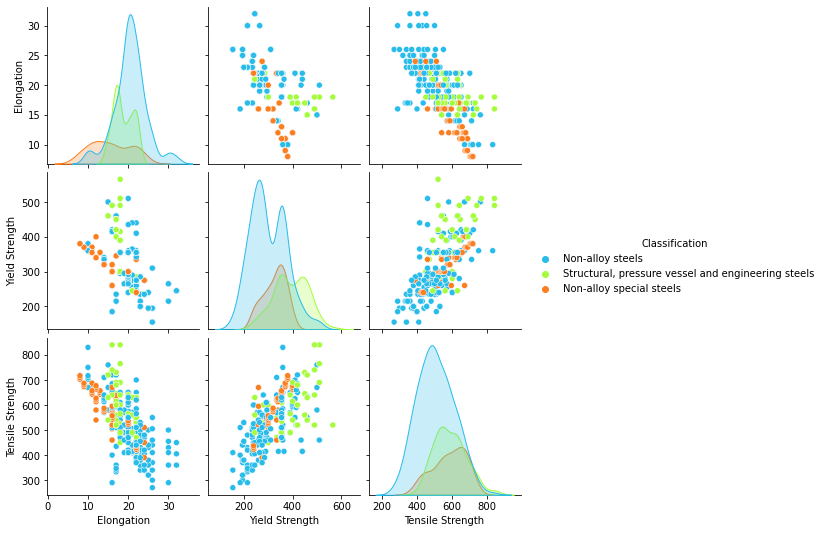

In [5]:
##Visualize the data
#Pari plot (for 3 classifications to better show the groups)
df2 = expand_df(df, 3)
df2_plot1 = df2[(df2["Classification"] != 'Non-alloy Quality steels') & 
                (df2["Classification"] != 'Alloy Steels')]
sns.pairplot(df2_plot1.loc[:, ["Elongation", "Yield Strength", "Tensile Strength", "Classification"]], 
             kind="scatter", hue="Classification", palette="turbo")
plt.show()
plt.close()

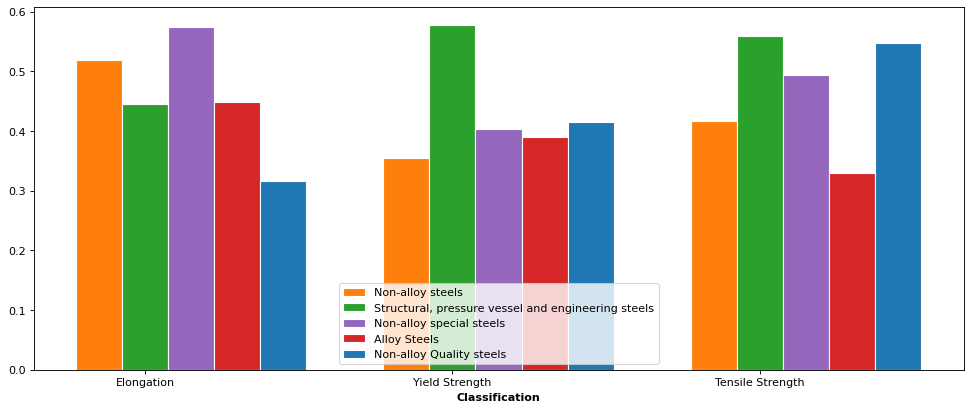

In [6]:
#Stacked bars to better visualize the data
#Normalize the data first
df2_min_max_scaled = df2.copy()
for column in df2_min_max_scaled.columns[2:5]:
    df2_min_max_scaled[column] = (df2_min_max_scaled[column] - df2_min_max_scaled[column].min()) / (df2_min_max_scaled[column].max() - df2_min_max_scaled[column].min())
x = df2_min_max_scaled.loc[:, ["Elongation", "Yield Strength", "Tensile Strength", "Classification"]]

# set width of bars
barWidth = 0.15
 
# set heights of bars
classifications = ['Non-alloy steels',
       'Structural, pressure vessel and engineering steels',
       'Non-alloy special steels',
        'Alloy Steels',
        'Non-alloy Quality steels']
bars1 = [x[x["Classification"] == 'Non-alloy steels']["Elongation"].mean(),
         x[x["Classification"] == 'Non-alloy steels']["Yield Strength"].mean(),
         x[x["Classification"] == 'Non-alloy steels']["Tensile Strength"].mean()
         ]
bars2 = [x[x["Classification"] == 'Structural, pressure vessel and engineering steels']["Elongation"].mean(),
         x[x["Classification"] == 'Structural, pressure vessel and engineering steels']["Yield Strength"].mean(),
         x[x["Classification"] == 'Structural, pressure vessel and engineering steels']["Tensile Strength"].mean()
        ]
bars3 = [x[x["Classification"] == 'Alloy Steels']["Elongation"].mean(),
         x[x["Classification"] == 'Alloy Steels']["Yield Strength"].mean(),
         x[x["Classification"] == 'Alloy Steels']["Tensile Strength"].mean()
         ]
bars4 = [x[x["Classification"] == 'Non-alloy Quality steels']["Elongation"].mean(),
         x[x["Classification"] == 'Non-alloy Quality steels']["Yield Strength"].mean(),
         x[x["Classification"] == 'Non-alloy Quality steels']["Tensile Strength"].mean()
        ]
bars5 = [x[x["Classification"] == 'Non-alloy special steels']["Elongation"].mean(),
         x[x["Classification"] == 'Non-alloy special steels']["Yield Strength"].mean(),
         x[x["Classification"] == 'Non-alloy special steels']["Tensile Strength"].mean()
        ]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

 
# Make the plot
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)
plt.bar(r1, bars1, color='tab:orange', width=barWidth, edgecolor='white', label='Non-alloy steels')
plt.bar(r2, bars2, color='tab:green', width=barWidth, edgecolor='white', label='Structural, pressure vessel and engineering steels')
plt.bar(r3, bars3, color='tab:purple', width=barWidth, edgecolor='white', label='Non-alloy special steels')
plt.bar(r4, bars4, color='tab:red', width=barWidth, edgecolor='white', label='Alloy Steels')
plt.bar(r5, bars5, color='tab:blue', width=barWidth, edgecolor='white', label='Non-alloy Quality steels')

 
# Add xticks on the middle of the group bars
plt.xlabel('Classification', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ["Elongation", "Yield Strength", "Tensile Strength"])
 
# Create legend & Show graphic
plt.legend(classifications, loc = 8)
plt.show()

In [51]:
##Train classification models
#KNN model
from sklearn.neighbors import KNeighborsClassifier

#train model
def run_model_KNN(n):
    x_train, x_test, y_train, y_test = split_data()
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(x_train, y_train)
    print("KNN accuracy is: {:.2f}".format(clf.score(x_test, y_test)))

#test new datapoint
def test_point_KNN(point, n):
    norm_point = normalize_point(point)
    x_train, x_test, y_train, y_test = split_data()
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(x_train, y_train)
    print("Model prediction for is: " + str(clf.predict(norm_point)))

#Run the model and print the accuracy
scores = run_model_KNN(10)

KNN accuracy is: 0.89


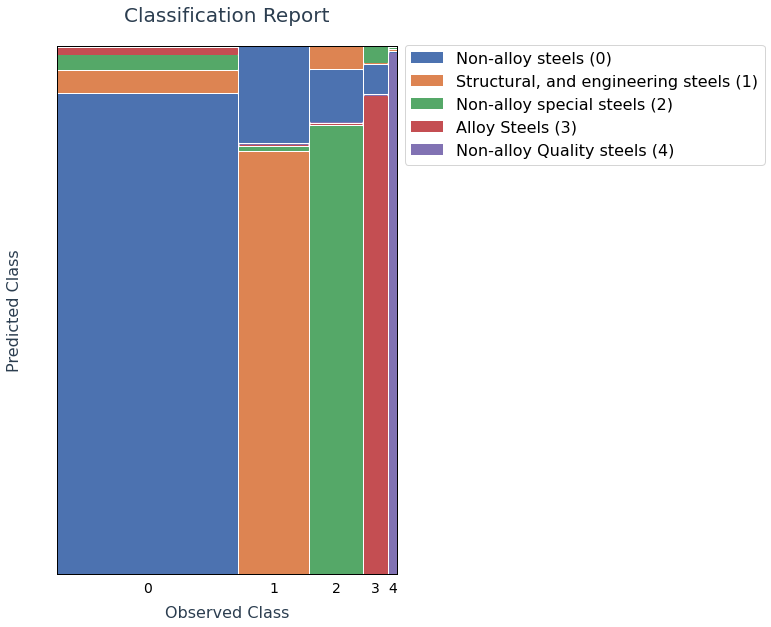

In [49]:
##KNN assessment using mosaic plot
##Mosai plot: For each classification it plots its predictions. 
##(ideal case: for class 1, the model will only predict class 1 and no other classes)

x_train, x_test, y_train, y_test = split_data()
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

class_1 = pred_list('Non-alloy steels', y_test, y_pred)
class_2 = pred_list('Structural, pressure vessel and engineering steels', y_test, y_pred)
class_3 = pred_list('Non-alloy special steels', y_test, y_pred)
class_4 = pred_list('Alloy Steels', y_test, y_pred)
class_5 = pred_list('Non-alloy Quality steels', y_test, y_pred)

results=  [class_1, class_2, class_3, class_4, class_5]
nclass_classification_mosaic_plot(5, results)

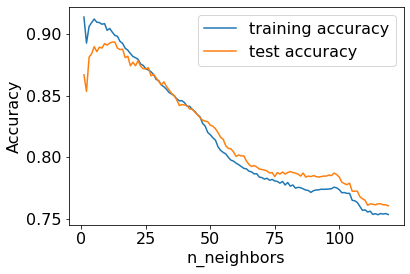

In [52]:
#Visualize the effect of k-neighbours
x_train, x_test, y_train, y_test = split_data()

training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 120)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [53]:
#Random forest model
from sklearn.ensemble import RandomForestClassifier

#train model
def run_model_forest(n):
    x_train, x_test, y_train, y_test = split_data()
    forest = RandomForestClassifier(n_estimators=n, random_state=1)
    forest.fit(x_train, y_train)
    print("Test set accuracy for is: {:.2f}".format(forest.score(x_test, y_test)))
    
#test new datapoint
def test_point_RF(point, n):
    norm_point = normalize_point(point)
    x_train, x_test, y_train, y_test = split_data()
    forest = RandomForestClassifier(n_estimators=n, random_state=0)
    forest.fit(x_train, y_train)
    print("Model prediction for is: " + str(forest.predict(norm_point)))

#Run the model and print the accuracy
run_model_forest(10)

Test set accuracy for is: 0.87


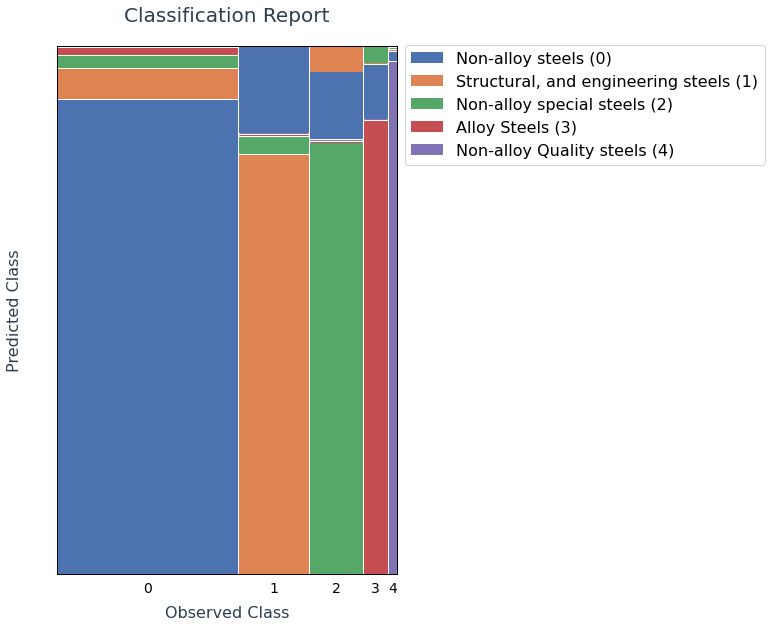

In [50]:
##random forest assessment using mosaic plot

x_train, x_test, y_train, y_test = split_data()
forest = RandomForestClassifier(n_estimators=10, random_state=1)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

class_1 = pred_list('Non-alloy steels', y_test, y_pred)
class_2 = pred_list('Structural, pressure vessel and engineering steels', y_test, y_pred)
class_3 = pred_list('Non-alloy special steels', y_test, y_pred)
class_4 = pred_list('Alloy Steels', y_test, y_pred)
class_5 = pred_list('Non-alloy Quality steels', y_test, y_pred)

results=  [class_1, class_2, class_3, class_4, class_5]
nclass_classification_mosaic_plot(5, results)

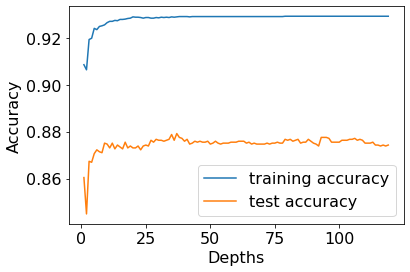

In [54]:
#Visualize the effect of the depth of the random forest
x_train, x_test, y_train, y_test = split_data()

training_accuracy = []
test_accuracy = []
estimators_settings = range(1, 120)

for estimater in estimators_settings:
    # build the model
    forest = RandomForestClassifier(n_estimators=estimater, random_state=1)
    forest.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy.append(forest.score(x_train, y_train))
    # record generalization accuracy
    test_accuracy.append(forest.score(x_test, y_test))
    
plt.plot(estimators_settings, training_accuracy, label="training accuracy")
plt.plot(estimators_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Depths")
plt.legend()

In [48]:
#Function to create mosaic plot, which visualizes classification model's accuracy

def nclass_classification_mosaic_plot(n_classes, results):
    steel_lables = ['Non-alloy steels (0)',
       'Structural, and engineering steels (1)',
       'Non-alloy special steels (2)', 'Alloy Steels (3)',
       'Non-alloy Quality steels (4)']
    """
    build a mosaic plot from the results of a classification
    
    parameters:
    n_classes: number of classes
    results: results of the prediction in form of an array of arrays
    
    In case of 3 classes the prdiction could look like
    [[10, 2, 4],
     [1, 12, 3],
     [2, 2, 9]
    ]
    where there is one array for each class and each array holds the
    predictions for each class [class 1, class 2, class 3].
    
    This is just a prototype including colors for 6 classes.
    """
    class_lists = [range(n_classes)]*2
    mosaic_tuples = tuple(itertools.product(*class_lists))
    
    res_list = results[0]
    for i, l in enumerate(results):
        if i == 0:
            pass
        else:
            tmp = deque(l)
            tmp.rotate(-i)
            res_list.extend(tmp)
    data = {t:res_list[i] for i,t in enumerate(mosaic_tuples)}

    fig, ax = plt.subplots(figsize=(11, 9))
    plt.rcParams.update({'font.size': 16})

    font_color = '#2c3e50'
    pallet = sns.color_palette('deep')
    colors = deque(pallet[:n_classes])
    all_colors = []
    for i in range(n_classes):
        if i > 0:
            colors.rotate(-1)
        all_colors.extend(colors)

    props = {(str(a), str(b)):{'color':all_colors[i]} for i,(a, b) in enumerate(mosaic_tuples)}

    labelizer = lambda k: ''

    p = mosaic(data, labelizer=labelizer, properties=props, ax=ax)

    title_font_dict = {
        'fontsize': 20,
        'color' : font_color,
    }
    axis_label_font_dict = {
        'fontsize': 16,
        'color' : font_color,
    }

    ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax.axes.yaxis.set_ticks([])
    ax.tick_params(axis='x', which='major', labelsize=14)

    ax.set_title('Classification Report', fontdict=title_font_dict, pad=25)
    ax.set_xlabel('Observed Class', fontdict=axis_label_font_dict, labelpad=10)
    ax.set_ylabel('Predicted Class', fontdict=axis_label_font_dict, labelpad=35)

    legend_elements = [Patch(facecolor=all_colors[i], label=steel_lables[i]) for i in range(n_classes)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.018), fontsize=16)

    plt.tight_layout()
    plt.show()
    
#Function to prepare lists for mosaic-plot function
def pred_list(classification, y_test, y_pred):
    class_1 = [0]*5
    for i in range(len(list(y_test))):
        if list(y_test)[i] == classification:
            if y_pred[i] == 'Non-alloy steels':
                class_1[0] += 1
            elif y_pred[i] == 'Structural, pressure vessel and engineering steels':
                class_1[1] += 1
            elif y_pred[i] == 'Non-alloy special steels':
                class_1[2] += 1
            elif y_pred[i] == 'Alloy Steels':
                class_1[3] += 1
            elif y_pred[i] == 'Non-alloy Quality steels':
                class_1[4] += 1
    return class_1